<a href="https://colab.research.google.com/github/foxtrotmike/AS/blob/master/AS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

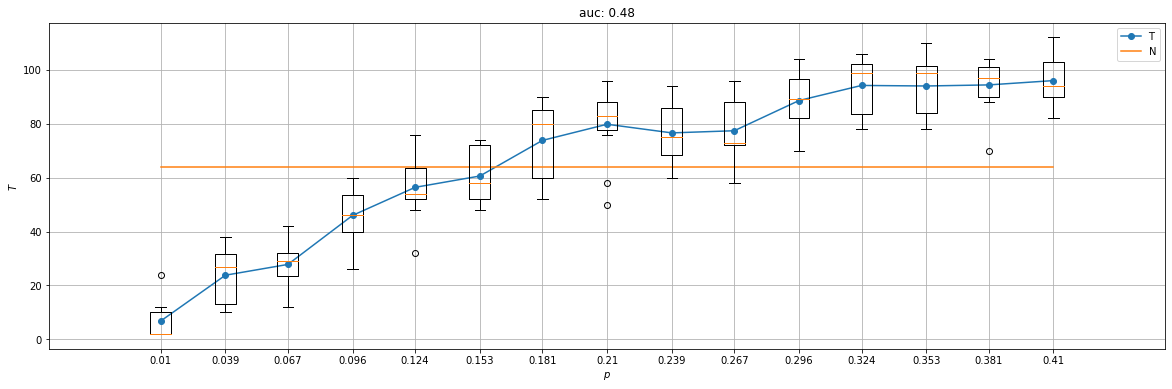

In [182]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  2 17:32:46 2020
np.array_split(idx, 2**v)
@author: fayya
"""

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import collections
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm.notebook import tqdm
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    if debug:
      dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

def getChildrenLeaves(T):
    if T.is_leaf():
        return T.id
    return (getChildrenLeaves(T.left),getChildrenLeaves(T.right))

def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
from collections import deque
    
def BFT(node,L,B):
    node.level = 1
    queue = deque([node])
    output = []
    current_level = node.level
    n_tests = 0
    while len(queue)>0:
          current_node = queue.popleft()           
          if(current_node.level > current_level):
              output.append("\n")
              current_level += 1

          output.append(str(current_node.id)+',')

          if current_node.left is not  None:
             current_node.left.level = current_level + 1 
             n_tests+=1
             if current_node.left.is_leaf() or np.any(L[list(flatten(getChildrenLeaves(current_node.left)))]):      #testing the left half    
                 queue.append(current_node.left) 
                 

          if current_node.right is not None:
             current_node.right.level = current_level + 1 
             n_tests+=1
             if current_node.right.is_leaf() or np.any(L[list(flatten(getChildrenLeaves(current_node.right)))]):  #testing the right half
                 queue.append(current_node.right)  
                                
 
    return n_tests,''.join(output)
def sigmoid(x):
  return 1.0/(1+np.exp(-x))

def simulate(N,p,n):
    L = 1.0*(np.random.rand(N)<p) #original "unknown" labels (positive or negative)       
    #Belief Settings
    if n>=0:
        B = L+0    
        B[L==1]+=n*np.random.randn(np.sum(L==1))
        B[L==0]+=n*np.random.randn(np.sum(L==0))
    else:
        B = np.random.rand(N)
        
    B = (B-np.min(B))/(np.max(B)-np.min(B))
    idx = list(range(len(L)))
    idx = np.argsort(B)    
    B,L = B[idx], L[idx]

    X = np.atleast_2d(sigmoid(5*B)).T
    
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(X)
    #plt.title('Hierarchical Clustering Dendrogram')
    #plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    #plt.show()
    # plot the top three levels of the dendrogram
    Z = plot_dendrogram(model, truncate_mode='level', p=-1)
    R, nodelist = hierarchy.to_tree(Z, rd=True)      
    
    CC = getChildrenLeaves(R)
    
    n_tests,out = BFT(R,L,B)
    try:
      auc = roc_auc_score(L,B)
    except ValueError as e:
      #print(e)
      auc = 0.0
    
    
    if debug:
        print(out)
        print('####')
        print(np.nonzero(L)[0])
        print('####')
        print("N:",N)
        print("Positives:",np.sum(L))
        print("Tests:",n_tests)
        bins=np.linspace(-5,5,20)
        hp,bp = np.histogram(B[L==1],bins=bins,density=True)
        hn,bn = np.histogram(B[L==0],bins=bins,density=True)
        bins=bins[:-1]
        #plt.figure();plt.plot(bins,hp,'r-');plt.plot(bins,hn,'b-');plt.show()    
        fpr, tpr, thresholds = roc_curve(L, B)        
        plt.figure();plt.plot(fpr,tpr);plt.title(str(auc))
        
    D = list(flatten([[int(n) for n in z.split(',') if len(n)] for z in out.split('\n')]))
    assert len(set(np.nonzero(L)[0]).difference(D))==0 #ensure that all are tested
    #print(len(D),n_tests)
    
    #assert len(D)==n_tests #ensure that all are tested
    return n_tests, auc, np.sum(L),(CC,L,B)
    
if __name__=='__main__':
    debug = False
    plt.close('all')
    trials = 10
    N =int(2**6)    
    n = -1
    Z = []
    for p in tqdm(np.linspace(0.01,0.41,15)):
        z = []
        for _ in range(trials):
            T, auc,P,_ = simulate(N,p,n)
            z.append((N,p,n,auc,P,T))
        Z.append(z)
    Z = np.array(Z)
    auc = [np.mean(z[:,-3]) for z in Z]
    x = [np.mean(z[:,1]) for z in Z]
    xx = [round(xx,3) for xx in x]
    y = [np.mean(z[:,-1]) for z in Z]
    data = [z[:,-1] for z in Z]
    fig = plt.figure(figsize=(20, 6))    
    plt.plot(xx,y,'o-')
    plt.plot(xx,[N]*len(xx))
    plt.legend(['T','N'])
    locs, labels = plt.xticks() 
    plt.boxplot(data, positions=xx, widths = (xx[2]-xx[1])/3,notch=False)
    plt.xticks(xx)
    plt.axis('tight')
    plt.grid()#
    
    plt.xlim(min(xx)-0.05, max(xx)+0.05)
    plt.xlabel('$p$')
    plt.ylabel('$T$')
    plt.title('auc: '+str(round(np.mean(auc),2)))
    plt.show()

    


62,
####
[]
####
N: 32
Positives: 0.0
Tests: 2
(((0, ((4, 5), (1, (2, 3)))), ((((31, (29, 30)), (23, ((27, 28), (24, (25, 26))))), (((22, (20, 21)), (17, (18, 19))), (14, (15, 16)))), ((6, 7), ((11, (12, 13)), (10, (8, 9)))))), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.        , 0.0757236 , 0.10178278, 0.10523   , 0.14553317,
       0.16479706, 0.25997703, 0.32352155, 0.37956526, 0.39718693,
       0.42198626, 0.46667135, 0.48236757, 0.4989316 , 0.58454361,
       0.62312435, 0.65534915, 0.68047513, 0.70100347, 0.70862972,
       0.72777588, 0.74068289, 0.76199612, 0.81501254, 0.83362102,
       0.84868006, 0.8504713 , 0.86527458, 0.87434608, 0.98873234,
       0.9903295 , 1.        ]))


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ValueError: ignored

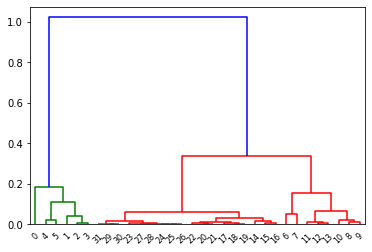

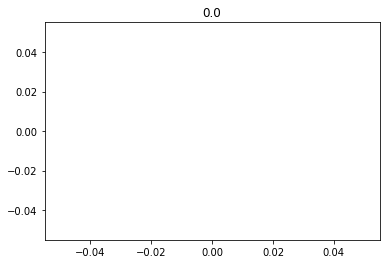

In [203]:
import scipy.stats as ss
debug = True

T, auc,P,out = simulate(32,0.1,-0.5)
print(out)
CC,L,B = out
print(len(L)-np.min(np.nonzero(L)[0]))
print(np.mean(len(L)-np.nonzero(L)[0])/len(L))

In [0]:
from collections import Counter
D = Counter(list(flatten(out)))

In [23]:
D

Counter({0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         62: 1,
  

In [24]:
CC

NameError: ignored